c:\Users\mcant\OneDrive\Documents\GitHub\CV-CNNs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mcant\OneDrive\Documents\GitHub\CV-CNNs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


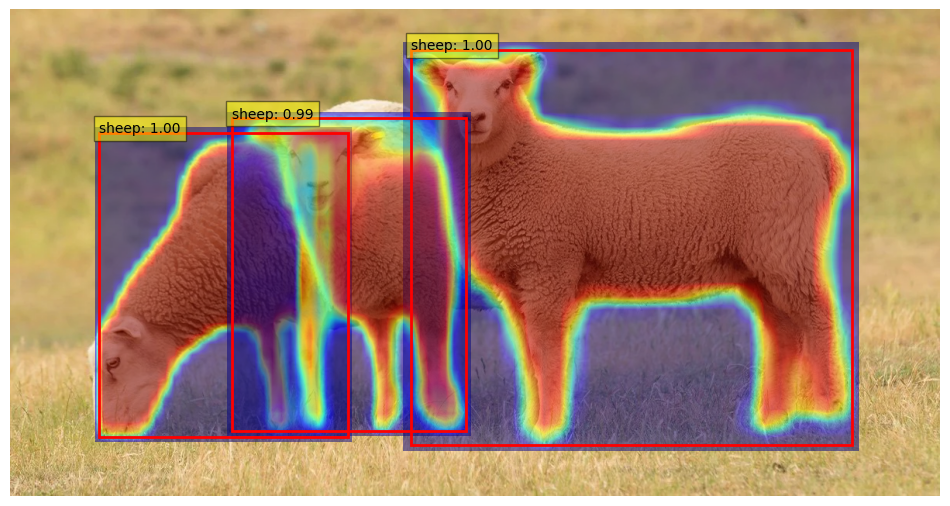

In [1]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    return image, image_tensor

# Function to perform object segmentation
def segment_objects(image_tensor):
    with torch.no_grad():
        prediction = model(image_tensor)
    return prediction[0]

# Function to visualize the segmentation results
def visualize_segmentation(image, masks, boxes, labels, scores, threshold=0.7):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()
    
    # COCO dataset class names
    coco_names = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
        'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
        'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    for mask, box, label, score in zip(masks, boxes, labels, scores):
        if score > threshold:
            mask = mask.squeeze().cpu().numpy()  # Ensure mask is 2D
            box = box.cpu().numpy()
            
            # Display segmentation mask
            masked = np.ma.masked_where(mask == 0, mask)
            plt.imshow(masked, alpha=0.5, cmap='jet')
            
            # Display bounding box
            x, y, w, h = box
            rect = plt.Rectangle((x, y), w-x, h-y, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            
            # Display class label and score
            class_name = coco_names[label]
            plt.text(x, y, f'{class_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Load and process an image
image_path = "sheep-grazing-on-pasture-up-close.png"  # Replace with your image path
image, image_tensor = load_image(image_path)

# Perform object segmentation
prediction = segment_objects(image_tensor)

# Extract prediction results
masks = prediction['masks']
boxes = prediction['boxes']
labels = prediction['labels']
scores = prediction['scores']

# Visualize the results
visualize_segmentation(image, masks, boxes, labels, scores)

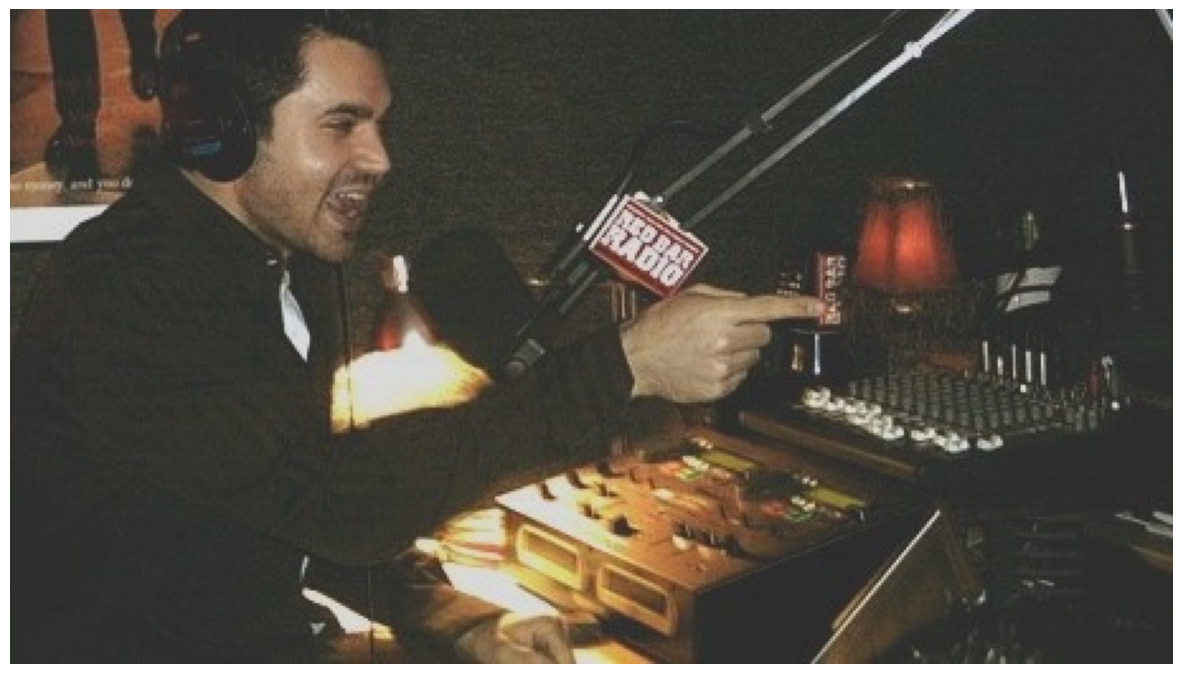

In [6]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the SAM model
def load_sam_model(checkpoint_path):
    model_type = "vit_h"  # You can change this to "vit_l" or "vit_b" for smaller models
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device)
    return sam

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return np.array(image)

# Function to perform object segmentation
def segment_objects(image, predictor, num_points=10):
    predictor.set_image(image)
    
    # Generate random points for segmentation
    h, w = image.shape[:2]
    points = np.random.rand(num_points, 2)
    points[:, 0] *= h
    points[:, 1] *= w
    points = points.astype(int)

    # Get segmentation masks
    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=np.ones(num_points),  # Assume all points are foreground
        multimask_output=True
    )
    
    return masks, scores

# Function to visualize the segmentation results
def visualize_segmentation(image, masks, scores, threshold=0.93):
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    ax = plt.gca()

    for i, (mask, score) in enumerate(zip(masks, scores)):
        if score > threshold:
            masked = np.ma.masked_where(mask == 0, mask)
            plt.imshow(masked, alpha=0.5, cmap=plt.cm.get_cmap('jet')(i / len(masks)))
            
            # Display score
            y, x = np.where(mask)
            if len(y) > 0 and len(x) > 0:
                plt.text(x.mean(), y.mean(), f'Score: {score:.2f}', 
                         bbox=dict(facecolor='white', alpha=0.7), ha='center', va='center')

    plt.axis('off')
    plt.show()

# Load the SAM model
checkpoint_path = "sam_vit_h_4b8939.pth"  # Replace with your SAM checkpoint path
sam = load_sam_model(checkpoint_path)
predictor = SamPredictor(sam)

# Load and process an image
image_path = "redbar.png"  # Replace with your image path
image = load_image(image_path)

# Perform object segmentation
masks, scores = segment_objects(image, predictor)

# Visualize the results
visualize_segmentation(image, masks, scores)

In [8]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_pil_image
import clip

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the SAM model
def load_sam_model(checkpoint_path):
    model_type = "vit_h"
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device)
    return sam

# Load CLIP model
def load_clip_model():
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess

# Function to load and preprocess an image
def load_image(image_path, clip_preprocess):
    image = Image.open(image_path).convert("RGB")
    clip_image = clip_preprocess(image).unsqueeze(0).to(device)
    sam_image = np.array(image)
    return image, clip_image, sam_image

# Function to get attention map from CLIP
def get_clip_attention(model, image, text):
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(text).to(device))
        image_features = model.encode_image(image)
        
        # Compute similarity between image and text features
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        # Get the attention map
        attention_map = similarity.reshape(1, 1, int(image.shape[2] / 32), int(image.shape[3] / 32))
        attention_map = torch.nn.functional.interpolate(attention_map, size=(image.shape[2], image.shape[3]), mode='bilinear')
        attention_map = attention_map.squeeze().cpu().numpy()
        
    return attention_map

# Function to get points from attention map
def get_points_from_attention(attention_map, num_points=10):
    # Flatten the attention map
    flat_attention = attention_map.flatten()
    
    # Get indices of top attention points
    top_indices = np.argsort(flat_attention)[-num_points:]
    
    # Convert indices to 2D coordinates
    points = np.array(np.unravel_index(top_indices, attention_map.shape)).T
    
    # Normalize points to image coordinates
    points = points * (224 / attention_map.shape[0])
    
    return points

# Function to perform object segmentation
def segment_objects(image, predictor, points):
    predictor.set_image(image)
    
    masks, _, _ = predictor.predict(
        point_coords=points,
        point_labels=np.ones(len(points)),  # Assume all points are foreground
        multimask_output=False
    )
    
    return masks[0]  # Return only the first mask

# Function to visualize the segmentation results
def visualize_segmentation(image, mask, text):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.6, cmap='cool')
    plt.title(f'Segmentation for: "{text}"')
    plt.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load models
    sam_checkpoint_path = "sam_vit_h_4b8939.pth"  # Replace with your SAM checkpoint path
    sam = load_sam_model(sam_checkpoint_path)
    predictor = SamPredictor(sam)
    
    clip_model, clip_preprocess = load_clip_model()

    # Load and process an image
    image_path = "MYERS.png"  # Replace with your image path
    original_image, clip_image, sam_image = load_image(image_path, clip_preprocess)

    # Print shape of clip_image for debugging
    print("CLIP image shape:", clip_image.shape)

    # Get text prompt from user
    text_prompt = input("Enter a text description of what you want to segment: ")

    # Get attention map from CLIP
    attention_map = get_clip_attention(clip_model, clip_image, text_prompt)

    # Print shape of attention_map for debugging
    print("Attention map shape:", attention_map.shape)

    # Get points from attention map
    points = get_points_from_attention(attention_map)

    # Perform object segmentation
    mask = segment_objects(sam_image, predictor, points)

    # Visualize the results
    visualize_segmentation(original_image, mask, text_prompt)

CLIP image shape: torch.Size([1, 3, 224, 224])


RuntimeError: shape '[1, 1, 7, 7]' is invalid for input of size 1

CLIP image shape: torch.Size([1, 3, 224, 224])
Attention map shape: (224, 224)


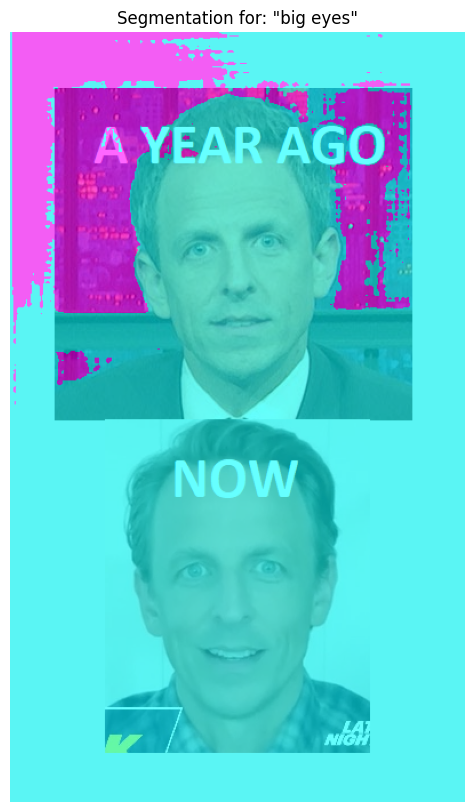

In [10]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from torchvision.transforms import Resize, ToTensor, Normalize
import clip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_sam_model(checkpoint_path):
    model_type = "vit_h"
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device)
    return sam

def load_clip_model():
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess

def load_image(image_path, clip_preprocess):
    image = Image.open(image_path).convert("RGB")
    clip_image = clip_preprocess(image).unsqueeze(0).to(device)
    sam_image = np.array(image)
    return image, clip_image, sam_image

def get_clip_attention(model, image, text):
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(text).to(device))
        image_features = model.encode_image(image)
        
        # Compute similarity between image and text features
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        # Create a uniform attention map
        attention_map = torch.ones((1, 1, 224, 224), device=device) * similarity.item()
        attention_map = attention_map.squeeze().cpu().numpy()
        
    return attention_map

def get_points_from_attention(attention_map, num_points=10):
    # Generate random points
    h, w = attention_map.shape
    points = np.random.rand(num_points, 2)
    points[:, 0] *= h
    points[:, 1] *= w
    points = points.astype(int)
    
    return points

def segment_objects(image, predictor, points):
    predictor.set_image(image)
    
    masks, _, _ = predictor.predict(
        point_coords=points,
        point_labels=np.ones(len(points)),  # Assume all points are foreground
        multimask_output=False
    )
    
    return masks[0]  # Return only the first mask

def visualize_segmentation(image, mask, text):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.6, cmap='cool')
    plt.title(f'Segmentation for: "{text}"')
    plt.axis('off')
    plt.show()

sam_checkpoint_path = "sam_vit_h_4b8939.pth"  # Replace with your SAM checkpoint path
sam = load_sam_model(sam_checkpoint_path)
predictor = SamPredictor(sam)

clip_model, clip_preprocess = load_clip_model()

image_path = "MYERS.png"  # Replace with your image path
original_image, clip_image, sam_image = load_image(image_path, clip_preprocess)

print("CLIP image shape:", clip_image.shape)

text_prompt = input("Enter a text description of what you want to segment: ")

attention_map = get_clip_attention(clip_model, clip_image, text_prompt)
print("Attention map shape:", attention_map.shape)

points = get_points_from_attention(attention_map)

mask = segment_objects(sam_image, predictor, points)

visualize_segmentation(original_image, mask, text_prompt)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import VOCDetection
from torchvision.ops import nms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Define the SSD model
class SimpleSSD(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSSD, self).__init__()
        self.num_classes = num_classes
        
        # Use a pre-trained ResNet18 as the base network
        self.base_net = models.resnet18(pretrained=True)
        self.base_net = nn.Sequential(*list(self.base_net.children())[:-2])
        
        # Additional convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Prediction layers
        self.loc_layers = nn.Conv2d(512, 4 * 4, kernel_size=3, padding=1)
        self.conf_layers = nn.Conv2d(512, num_classes * 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.base_net(x)
        x = self.conv_layers(x)
        
        loc = self.loc_layers(x).permute(0, 2, 3, 1).contiguous()
        conf = self.conf_layers(x).permute(0, 2, 3, 1).contiguous()
        
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)
        
        return loc, conf

# Custom dataset class for PASCAL VOC
class VOCDataset(VOCDetection):
    def __init__(self, root, year, image_set, download, transform):
        super().__init__(root, year, image_set, download)
        self.transform = transform
        
        self.class_to_idx = {
            'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4,
            'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10,
            'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14,
            'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20
        }

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        
        boxes = []
        labels = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            boxes.append([int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])])
            labels.append(self.class_to_idx[obj['name']])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.long)
        
        if self.transform:
            img, boxes = self.transform(img, boxes)
        
        return img, {'boxes': boxes, 'labels': labels}

# Custom transform to resize image and adjust bounding boxes
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, boxes):
        for t in self.transforms:
            image, boxes = t(image, boxes)
        return image, boxes

class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, boxes):
        old_size = image.size
        image = image.resize(self.size)
        
        # Adjust bounding boxes
        scale_x = self.size[0] / old_size[0]
        scale_y = self.size[1] / old_size[1]
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y
        
        return image, boxes

class ToTensor(object):
    def __call__(self, image, boxes):
        return transforms.ToTensor()(image), boxes

# Loss function
class MultiBoxLoss(nn.Module):
    def __init__(self, num_classes):
        super(MultiBoxLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, predictions, targets):
        loc_data, conf_data = predictions
        loc_t, conf_t = targets
        
        pos = conf_t > 0
        num_pos = pos.sum(dim=1)

        # Localization Loss (Smooth L1)
        loc_loss = nn.functional.smooth_l1_loss(loc_data[pos], loc_t[pos], reduction='sum')

        # Confidence Loss (Cross Entropy)
        batch_conf = conf_data.view(-1, self.num_classes)
        loss_c = nn.functional.cross_entropy(batch_conf, conf_t.view(-1), reduction='none')
        loss_c = loss_c.view(conf_t.size()[0], -1)
        loss_c[pos] = 0  # Filter out pos boxes for now
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        num_neg = torch.clamp(3*num_pos, max=pos.size(1)-1)
        neg = idx_rank < num_neg.expand_as(idx_rank)
        
        conf_loss = nn.functional.cross_entropy(batch_conf[pos+neg], conf_t.view(-1)[pos+neg], reduction='sum')

        N = num_pos.sum().float()
        loss = (loc_loss + conf_loss) / N

        return loss

# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, targets in dataloader:
        images = images.to(device)
        loc_t = targets['boxes'].to(device)
        conf_t = targets['labels'].to(device)
        
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, (loc_t, conf_t))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    detections = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            loc, conf = model(images)
            
            # Apply NMS and threshold
            scores, labels = conf.max(2)
            for i in range(images.size(0)):
                boxes = loc[i]
                score = scores[i]
                mask = score > 0.5
                boxes = boxes[mask]
                labels = labels[i][mask]
                keep = nms(boxes, score[mask], 0.5)
                detections.append((boxes[keep], labels[keep], score[mask][keep]))
    
    return detections

# Visualization function
def visualize_detections(image, detections, class_names):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(*detections):
        box = box.tolist()
        draw.rectangle(box, outline='red', width=2)
        draw.text((box[0], box[1]), f'{class_names[label]}: {score:.2f}', fill='red')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    num_classes = 21  # 20 classes + background
    num_epochs = 10
    batch_size = 16
    learning_rate = 0.001

    # Data transformations
    transform = Compose([
        Resize((300, 300)),
        ToTensor()
    ])

    # Create dataset and dataloader
    dataset = VOCDataset(root='./data', year='2012', image_set='train', download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: x)

    # Initialize the model
    model = SimpleSSD(num_classes).to(device)

    # Loss and optimizer
    criterion = MultiBoxLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        loss = train(model, dataloader, criterion, optimizer, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Save the model
    torch.save(model.state_dict(), 'ssd_object_detection_model.pth')
    print("Training complete. Model saved.")

    # Evaluation
    eval_dataset = VOCDataset(root='./data', year='2012', image_set='val', download=True, transform=transform)
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: x)
    detections = evaluate(model, eval_dataloader, device)

    # Visualize some results
    class_names = list(dataset.class_to_idx.keys())
    for i in range(5):  # Visualize 5 random images
        img, _ = eval_dataset[i]
        visualize_detections(img, detections[i], class_names)